In [18]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt # for making figures
from torch.utils.data import random_split
%matplotlib inline

In [225]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(min(len(w) for w in words))
print(words[:8])

32033
15
2
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [9]:
chars = sorted(list(set(''.join(words))))
chars.insert(0, ".")

ctoi = { c:i for i, c in enumerate(chars)}
itoc = { i:c for i, c in enumerate(chars)}
vocab_size = len(chars)

print(ctoi)
print(vocab_size)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
27


In [20]:
train_wd, valid_wd, test_wd = random_split(words, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(420))

In [61]:
def pad(string, char, length):
    d = length - len(string)
    return string + char * d
    
pad("apple", ".", 10)

'apple.....'

In [78]:
[pad("."*3+w, ".", 15) for w in words][:10]

['...emma........',
 '...olivia......',
 '...ava.........',
 '...isabella....',
 '...sophia......',
 '...charlotte...',
 '...mia.........',
 '...amelia......',
 '...harper......',
 '...evelyn......']

```
kkk
...steven
   steven.
```

- input:  seq_len
- output: seq_len - kernal_size + 1

In [227]:
kernel_size = 8
max_word_len = 15
x_len = max_word_len + kernel_size + 1 # 19
y_len = x_len - kernel_size + 1 

def char_idx(word):
    return [ctoi[c] for c in word]

def build_dataset(words):
    X = []
    Y = []
    L = []
    
    for w in words:
        x = "." * kernel_size + w + "."
        x = pad(x, ".", x_len)
        
        y = w + "."
        y_n = len(y)
        y = pad(y, ".", y_len)
        
        X.append(char_idx(x))
        Y.append(char_idx(y))
        L.append(y_n)

    return torch.tensor(X), torch.tensor(Y), torch.tensor(L)

# (sample_size, seq_len)
train_x, train_y, train_l = build_dataset(train_wd)
valid_x, valid_y, valid_l = build_dataset(valid_wd)

train_x.shape, train_y.shape, train_l.shape

(torch.Size([25627, 24]), torch.Size([25627, 17]), torch.Size([25627]))

In [178]:
train_l[0], train_wd[0]

(tensor(7), 'jaysen')

In [179]:
class Transpose(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.T
    
    def string(self):
        return "Transpose"

In [319]:
class Permute(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.permute(self.dim)
    
    def string(self):
        return "Permute"

In [358]:
embed_size = 16
hidden_size = 100

linear = nn.Linear(hidden_size, vocab_size) # (batch, seq_out, vocab)
linear.weight.data *= 0.0001
linear.bias.data.fill_(0)

conv = nn.Conv1d(in_channels=embed_size, out_channels=hidden_size, kernel_size=kernel_size) # (batch, hidden, seq_out)
nn.init.xavier_uniform_(conv.weight, nn.init.calculate_gain("tanh"))

# input (batch, seq)
model = nn.Sequential(
    nn.Embedding(vocab_size, embed_size), # (batch, seq, embed)
    Permute((0, 2, 1)), # (batch, embed, seq)
    conv,
    Permute((0, 2, 1)), # (batch, seq_out, hidden)
    nn.Tanh(),
    linear # (batch, seq_out, vocab)
)

for p in model.parameters():
    p.requires_grad = True
    
print(sum((p.nelement() for p in model.parameters())))

16059


In [352]:
@torch.no_grad()
def eval_split():    
    x = valid_x
    y = valid_y
    l = valid_l
    
    for p in model.parameters():
        p.grad = None
        
    mask = torch.zeros(y.shape)
    for i, l in enumerate(l):
        mask[i, 0:l] = torch.ones(l)
    mask = mask.view(-1)

    logits = model(x)
    loss = F.cross_entropy(logits.view(-1, 27), y.view(-1), reduction="none")    
    loss = mask @ loss / sum(mask)    
    
    return loss.item()

In [359]:
lossi = []
for i in range(50000):
    ix = torch.randint(0, train_x.shape[0], (32,))
    x = train_x[ix]
    y = train_y[ix]
    l = train_l[ix]
    
    for p in model.parameters():
        p.grad = None
        
    mask = torch.zeros(y.shape)
    for i, l in enumerate(l):
        mask[i, 0:l] = torch.ones(l)
    mask = mask.view(-1)

    logits = model(x)
    loss = F.cross_entropy(logits.view(-1, 27), y.view(-1), reduction="none")
    
    loss = mask @ loss / sum(mask)
    loss.backward()

    lr = 0.1 if len(lossi) < 10000 else 0.01
    for p in model.parameters():
        p.data += -lr * p.grad

    lossi.append(loss.item())
    
    if len(lossi) % 5000 == 0:
        print(f"{lossi[-1]:.4f}")

2.1144
2.0878
2.1213
2.0962
1.9526
2.0800
2.0809
2.2359
2.0945
2.0176


In [360]:
valid_loss = eval_split()

In [361]:
print(f"train: {torch.tensor(lossi[-10000:]).mean():.4f}")
print(f"valid: {valid_loss:.4f}")

train: 2.0424
valid: 2.0862


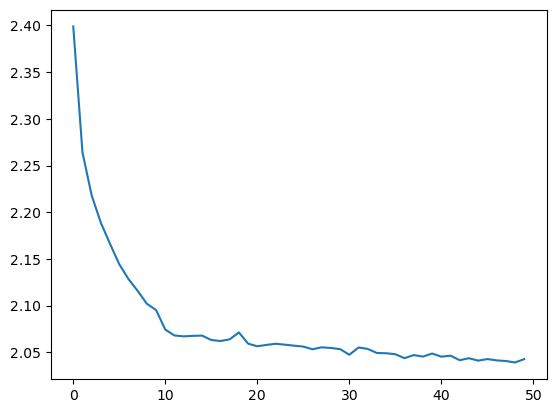

In [362]:
m = 1000
clip = len(lossi) - (len(lossi) % m)

l = torch.tensor(lossi[0:clip])
l = l.view(-1, m).mean(1)
plt.plot(l)

#### Log

Single example stocastic gradient
- train: 2.2232
- valid: 2.2155
  
Mini-batch gradient descent
- train: 2.1531
- valid: 2.1746

Mini-batch gradient descent (emb: 16, hidden: 64)
- train: 2.0666
- valid: 2.1058

In [367]:
for i in range(20):
    sample = [0] * kernel_size

    while(True):
        ctx = sample[-kernel_size:] 
        ctx = torch.tensor(ctx).view(1, -1) # (K)
        logits = model(ctx) # (1, 1, 27)
        logits = logits.view(vocab_size)
        prob = F.softmax(logits, 0)
        idx = torch.multinomial(prob, 1).item()
        sample.append(idx)

        if idx == 0 or len(sample) > 50:
            break

    word = "".join([itoc[idx] for idx in sample[kernel_size:-1]])
    print(word)

siel
anisho
gadxlyn
daelani
hasous
ismar
geislev
nakayla
jelcalne
mouraed
reypon
kenoct
caree
jesvin
brij
aplemahi
wyhit
raytsn
nyrolen
navella
